In [2]:
import bokeh.plotting as bpl
import cv2
import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import tifffile as tif
from time import time, sleep


try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour

from caiman.source_extraction import cnmf as cnmf
from scipy.sparse import csc_matrix
from scipy.misc import imresize
from scipy.signal import welch, fftconvolve
from scipy.interpolate import UnivariateSpline

from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.metrics import r2_score

from scipy.ndimage.filters import gaussian_filter

from caiman.source_extraction.cnmf.utilities import extract_DF_F, detrend_df_f

import pykalman as pk 
from matplotlib.colors import LogNorm

import pandas as pd

import h5py
bpl.output_notebook()

from jupyterthemes import jtplot
jtplot.style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [3]:
# load in CaImAn output

cmFile = r'C:/Users/bnste/Documents/scripts/jon_caiman_results/analysis_behavior_00001.hdf5'

    
def cellInfoCaimanHdf5(hdf5File):
    """
    Given a CaImAn output .hdf5 file, returns the spatial cell profiles, cell signal traces, and background profiles and traces
    Output:
    (cellProfs, signalTraces, bgProfs, bgTraces)
    cellProfs is a numCells x xDim x yDim array of spatial cell profiles
    signalTraces is a  tBins x numCells array of fluorescence traces from each cell
    bgProfs: nBGComps x xDim x yDim
    bgTraces: tBins x nBGComps
    """
    cellProfs = []
    signalTraces = []

    with h5py.File(hdf5File, mode='r') as cFile:
        est = cFile['estimates']
        Ainfo = est['A']
        signalTraces = np.transpose( np.array(est['C']) )
        Adata = np.array(Ainfo['data'])
        Aindices = np.array(Ainfo['indices'])
        Aindptr = np.array(Ainfo['indptr'])
        Ashape = np.array(Ainfo['shape'])
        A = csc_matrix((Adata,Aindices,Aindptr) , shape=Ashape ).transpose()
        A = np.array(A.todense())
        cellProfs = A.reshape((A.shape[0],np.array(est['dims'])[0] ,-1))
        f = np.array(est['f']).transpose()
        b = np.array(est['b']).transpose()
        b = b.reshape(b.shape[0],cellProfs.shape[1],cellProfs.shape[2])
    return (cellProfs, signalTraces, b, f)




# Caiman BG estimate
def getCaimanBg(startFrame=None,endFrame=None, mask=None, mode='caiman_only', origMov=None):
    """
    'mode' should be 'residual' (computed by subtracting caiman sources from origMov) or 'caiman_only' (directly from bg matrices) 
    """
    if mode not in ['residual', 'caiman_only']:
        raise Exception('mode must be caiman_only or residual')
    if (mode == 'residual') and (origMov is None):
        raise Exception('residual mode requires origMovie argument')
    if mask is None:
        if mode == 'caiman_only':
            return np.tensordot(b.transpose(0,2,1),f,axes=(0,1)).transpose((2,0,1))[startFrame:endFrame]
        elif mode == 'residual':
            return origMov - np.tensordot(C[startFrame:endFrame], A.transpose((0,2,1)),  axes=(1,0) )
    else:
        mask = mask / np.linalg.norm(mask)
        if mode == 'caiman_only':
            bMask = ( mask.reshape( (1,) + mask.shape ) * b.transpose(0,2,1) ).sum(axis=(-2,-1))
            return np.tensordot(bMask,f,axes=(0,1)).transpose()[startFrame:endFrame]
        elif mode == 'residual':
            mask = mask.reshape( (1,) + mask.shape )
            return ( origMov * mask  ).sum(axis=(-2,-1)) - np.tensordot(C[startFrame:endFrame], (A.transpose((0,2,1)) * mask).sum(axis=(-2,-1)), axes=(1,0) )  

# return caiman movie from within the given frames, containing the given source and background indices
## UNFINISHED
def getCaimanMovie(startFrame=None, endFrame=None, source_indices='all', bg_indices='all'):
    source_indices = None if (source_indices == 'all') else np.array([0]) if (source_indices == 'none') else np.array(source_indices)
    bg_indices = None if (bg_indices == 'all') else np.array([0]) if (bg_indices == 'none') else np.array(bg_indices)

    sourceTerm = np.tensordot(C[startFrame:endFrame], A.transpose((0,2,1)),  axes=(1,0) )
        
# get trial average of array.
# time index should be in position 0.
def trialAvg(arr, trialSize, idxStart=0, idxEnd=None):
    if idxEnd is None:
        idxEnd = len(arr)
    inputLength = idxEnd - idxStart
    if (inputLength % trialSize) != 0:
        raise Exception('Input length {} incompatible with trial size {} (remainder {})'.format(inputLength, trialSize, inputLength % trialSize))
    arr = arr[idxStart:idxEnd]
    return arr.reshape((int(arr.shape[0]/trialSize),trialSize) + arr.shape[1:], order='C').mean(axis=0)



A, C, b, f = cellInfoCaimanHdf5(cmFile)

cnm = cnmf.cnmf.load_CNMF(cmFile)
if len(cnm.estimates.dims)==1:
    cnm.estimates.dims = cnm.estimates.dims*2


In [46]:
C.shape[0]/30

15944

In [4]:
# get experimental info from hdf5 file

# sweep_****/analogScans row format: StimOnset, StimTime, TrialOn, Sniff, and FrameTrig
# stimOnset: when stimulation starts (step func)
# stimTime: when stimulation actually happens (step func)
# trialOn: step function for trial start/end
# sniff: sniff detector pressure reading
# frameTrig: frame start signal for scanimage

hdf5Behavior = h5py.File('C:/Users/bnste/Documents/scripts/jon_2p_data/JG24831_181210_field1_behavior_003_0001.h5')

#hdf5Behavior.visititems(print)

sweepKey = [x for x in hdf5Behavior.keys() if 'sweep' in x][0]
analogScans = hdf5Behavior[sweepKey + '/analogScans'].value
stimOnset, stimTime, trialOn, sniff, frameTrig = analogScans
timestamp = hdf5Behavior[sweepKey + '/timestamp'].value.flatten()


In [54]:
hdf5Behavior.visititems(print)

header <HDF5 group "/header" (42 members)>
header/AITerminalIDsOnDevice <HDF5 dataset "AITerminalIDsOnDevice": shape (8, 1), type "<f8">
header/AbsoluteProtocolFileName <HDF5 dataset "AbsoluteProtocolFileName": shape (1,), type "|S51">
header/AbsoluteUserSettingsFileName <HDF5 dataset "AbsoluteUserSettingsFileName": shape (1,), type "|O">
header/Acquisition <HDF5 group "/header/Acquisition" (34 members)>
header/Acquisition/ActiveChannelIndexFromChannelIndex <HDF5 dataset "ActiveChannelIndexFromChannelIndex": shape (6, 1), type "<f8">
header/Acquisition/ActiveChannelNames <HDF5 dataset "ActiveChannelNames": shape (5,), type "|S9">
header/Acquisition/AnalogChannelNames <HDF5 dataset "AnalogChannelNames": shape (6,), type "|S9">
header/Acquisition/AnalogChannelScales <HDF5 dataset "AnalogChannelScales": shape (6, 1), type "<f8">
header/Acquisition/AnalogChannelUnits <HDF5 dataset "AnalogChannelUnits": shape (6,), type "|S2">
header/Acquisition/AnalogDeviceNames <HDF5 dataset "AnalogDevice

header/FastProtocols <HDF5 group "/header/FastProtocols" (6 members)>
header/FastProtocols/element1 <HDF5 group "/header/FastProtocols/element1" (4 members)>
header/FastProtocols/element1/AutoStartType <HDF5 dataset "AutoStartType": shape (1,), type "|S10">
header/FastProtocols/element1/IsNonempty <HDF5 dataset "IsNonempty": shape (1, 1), type "<f8">
header/FastProtocols/element1/IsReady <HDF5 dataset "IsReady": shape (1, 1), type "<f8">
header/FastProtocols/element1/ProtocolFileName <HDF5 dataset "ProtocolFileName": shape (1,), type "|O">
header/FastProtocols/element2 <HDF5 group "/header/FastProtocols/element2" (4 members)>
header/FastProtocols/element2/AutoStartType <HDF5 dataset "AutoStartType": shape (1,), type "|S10">
header/FastProtocols/element2/IsNonempty <HDF5 dataset "IsNonempty": shape (1, 1), type "<f8">
header/FastProtocols/element2/IsReady <HDF5 dataset "IsReady": shape (1, 1), type "<f8">
header/FastProtocols/element2/ProtocolFileName <HDF5 dataset "ProtocolFileName": s

header/Triggering/StimulationTriggerScheme/Name <HDF5 dataset "Name": shape (1,), type "|S23">
header/Triggering/StimulationTriggerScheme/PFIID <HDF5 dataset "PFIID": shape (1, 1), type "<f8">
header/Triggering/StimulationTriggerSchemeIndex <HDF5 dataset "StimulationTriggerSchemeIndex": shape (1, 1), type "<f8">
header/Triggering/StimulationUsesAcquisitionTriggerScheme <HDF5 dataset "StimulationUsesAcquisitionTriggerScheme": shape (1, 1), type "<f8">
header/UserCodeManager <HDF5 group "/header/UserCodeManager" (5 members)>
header/UserCodeManager/ClassName <HDF5 dataset "ClassName": shape (1,), type "|O">
header/UserCodeManager/IsClassNameValid <HDF5 dataset "IsClassNameValid": shape (1, 1), type "<f8">
header/UserCodeManager/IsEnabled <HDF5 dataset "IsEnabled": shape (1, 1), type "<f8">
header/UserCodeManager/IsReady <HDF5 dataset "IsReady": shape (1, 1), type "<f8">
header/UserCodeManager/TheObject <HDF5 dataset "TheObject": shape (1, 1), type "<f8">
header/VersionString <HDF5 dataset

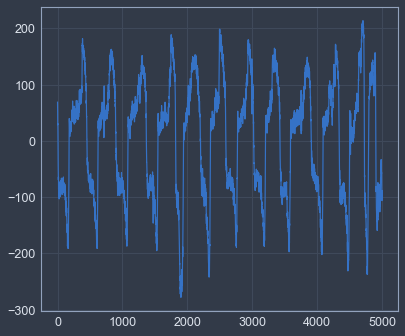

In [6]:
plt.plot(sniff[0:5000])